<a href="https://colab.research.google.com/github/karpad2/self-turning-adaptive_control/blob/main/ST_adaptive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#paraméterek és szükséges programok feltelepítése

In [ ]:
#!pip install slycot   # optional
#%matplotlib inline
!pip install control &>/dev/null
!apt install octave &>/dev/null
!pip install oct2py &>/dev/null
!apt install octave-control  &>/dev/null

In [ ]:
import control
import numpy as np
from oct2py import octave, Oct2Py
import matplotlib.pyplot as plt
from IPython.display import Image
import math

#plt.style.use('seaborn-whitegrid')
oc=Oct2Py()
oc.eval('pkg load control')
gen=10

Genetikus algoritmus beállítása:

In [ ]:
# Genetikus Algoritmus
#értékelés
#fitnesz érték
#keresztezés
egyedek_szama=6
oc.eval('cur=(randi(5,'+str(egyedek_szama)+',24))>=3');#8bit mindegyik értékre Kp;Ki;Kd 500 egyed
cur=oc.pull('cur')
def lineofarray(k,i):
  oc.push('tmp',k)
  oc.push('j',i)
  oc.eval("tmp2=tmp(j+1,:);")
  return oc.pull("tmp2")
def _calc(_l):
  oc.push('_l',_l)
  oc.eval('tmp=0;for i=1:8 tmp=tmp+(2^(7-(i-1)))*_l(i); end')
  return (oc.pull('tmp'))

def kpid(l):
  _oszto=32
  oc.push('l',l)
  oc.eval('tmp=l(1:8);')
  _Kp=(_calc(oc.pull('tmp'))/_oszto)
  oc.eval('tmp=l(8:16);')
  _Ki=(_calc(oc.pull('tmp'))/_oszto)
  oc.eval('tmp=l(16:24);')
  _Kd=(_calc(oc.pull('tmp'))/_oszto)
  return [_Kp,_Ki,_Kd]
def fitness(t,y): #fitnessz függvény x,y
  tmp=0
  kivánt_érték=1
  felfutási_sebbeség=0.03
  túllövés=0.05
  #display(y)
  for i in range(1,len(t)):
    if y[i]<kivánt_érték and t[i]<felfutási_sebbeség:
       tmp=tmp+1
    else:
       tmp=tmp-1
    if y[i]+((y[i])*túllövés)>kivánt_érték or y[i]+((y[i])*túllövés)<kivánt_érték and t[i]>felfutási_sebbeség:
       tmp=tmp+1
    else:
       tmp=tmp-1
    if (y[i]-(y[i])*túllövés)>kivánt_érték and t[i]>felfutási_sebbeség:
      tmp=tmp+1   
  
  return tmp

#kpid(lineofarray(cur,1))
def recomb():
#Recombination
 oc.eval("recombinated=[];")
 oc.eval(str("for i=1:2:length(selectedInds) "
    "r=randi(8); "
    "r1=randi(8); "
    "r2=randi(8); "
    "a=selected(i,:); " 
    "b=selected(i+1,:); "
    
    "c=0; "   
    "a1_part=a(1+c:r+c); "#gyerek_part1
    "b1_part=b(r+1+c:8+c); "#gyerek_part2
    "a2_part=b(1+c:r+c); "#gyerek_part1
    "b2_part=a(r+1+c:8+c); "#gyerek_part2 
    #"disp(length(a1_part)+length(b1_part)); "
    
    #"break; "
    
    "c=8;"   
    "c1_part=a(1+c:r+c); "#gyerek_part3
    "d1_part=b(r+1+c:8+c); "#gyerek_part4
    "c2_part=b(1+c:r+c); "#gyerek_part3
    "d2_part=a(r+1+c:8+c); "#gyerek_part4 
    #"disp(length(c2_part)+length(d2_part));  "
    #" end"))
    "c=16;"   
    "e1_part=a(1+c:r+c); "#gyerek_part5
    "f1_part=b(r+1+c:8+c); "#gyerek_part6
    "e2_part=b(1+c:r+c); "#gyerek_part5
    "f2_part=a(r+1+c:8+c); "#gyerek_part6 
    #"disp(length(e2_part)+length(f2_part)); "
    #" end"))
    "recombinated(i,:)=[a1_part,b1_part,c1_part,d1_part,e1_part,f1_part]; "
    " recombinated(i+1,:)=[a2_part,b2_part,c2_part,d2_part,e2_part,f2_part]; "
    #"tmp=[a2_part,b2_part,c2_part,d2_part,e2_part,f2_part]; " 
    #"disp(length(tmp)); "    
    " end"))
def mutation():
   #Mutation
    oc.eval("for i=1:length(selectedInds) "
        "for j=1:8 "
        "if(randi(10)==1) "# 1 a 10 hez mutál egyet
            "recombinated(i,j)=xor(recombinated(i,j)==1,1)*1; " #xorral bit hely csere
            " end " 
        " end "
    " end ")
def selection():
  oc.eval(str( "for i=1:length(fitness) "
 "for j=i+1:length(fitness) "
 "if(fitness(i)>fitness(j)) "
 "var=fitness(i); "
 "fitness(i)=fitness(j); "
 "fitness(j)=var; "
 "var=cur(i,:); "
 "cur(i,:)=cur(j,:); "
 "cur(j,:)=var; "
 "end "
 "end "
 "end "))

  oc.eval(str("avgFitness=mean(fitness); "
 "normFitness=fitness/avgFitness; "
 "percFitness=normFitness/length(fitness); "
 "fKum=100*cumsum(percFitness); "
 "rndNums=randi(100,1,length(fitness)) ;"
 "selectedInds=zeros(1,length(fitness)); "))

  oc.eval(str( "for i=1:length(fitness) "
 "rnd=rand()*100; "
 "for j=1:length(fitness) "
 "if fKum(j)>rnd  "
 " selectedInds(i)=j; "
 " break; "
 "end "
 "end "
 "end "));
 
  oc.eval(str("selected=[]; "
 "for i=1:length(selectedInds) "
 "selected(i,:)=cur(selectedInds(i),:); "
 "end "))


cur =

  1  1  1  0  1  0  0  1  0  0  0  1  1  1  0  0  1  0  1  0  1  1  0  1
  1  0  1  1  0  1  1  1  0  1  1  1  1  0  1  1  0  1  1  1  1  0  1  0
  1  0  1  1  1  0  0  1  1  0  0  1  1  1  1  1  1  1  0  1  1  0  1  0
  0  1  0  1  0  1  0  1  1  1  1  1  1  0  0  1  0  0  1  1  0  1  1  1
  1  0  0  1  1  1  0  0  1  1  1  1  1  0  0  0  1  0  1  1  0  1  1  0
  0  1  0  1  1  1  0  1  1  1  1  0  0  1  1  1  1  1  1  1  0  1  1  1



In [ ]:
#A = [[0, 1, 0],[0, -b/J, K/J],[0, -K/L, -R/L]]
#B = [[0] , [0] , [1/L]]
#C = [1, 0, 0];
#D = [0];
#motor_ss = control.ss(A,B,C,D)
#display(motor_ss)

In [ ]:
J = 3.2284E-6;
b = 3.5077E-6;
K = 0.0274;
R = 4;
L = 2.75E-6;
oc.push('J',J)
oc.push('b',b)
oc.push('K',K)
oc.push('R',R)
oc.push('L',L)
oc.eval("s=tf('s')")
oc.eval('P_motor = K/(s*((J*s+b)*(L*s+R)+K^2))')


Transfer function 's' from input 'u1' to output ...

 y1:  s

Continuous-time model.

Transfer function 'P_motor' from input 'u1' to output ...

                        0.0274
 y1:  -------------------------------------------
      8.878e-12 s^3 + 1.291e-05 s^2 + 0.0007648 s

Continuous-time model.


In [ ]:
def pid_cal(Kp,Ki=0,Kd=0):
  
  oc.push('Kp',Kp);
  oc.push('Ki',Kd);
  oc.push('Kd',Kd);
  oc.eval('C = pid(Kp,Ki)')
  oc.eval('sys_cl = feedback(C*P_motor,1)')
  oc.eval('[y,_t,x]=step(sys_cl,t);')
  return([oc.pull('y'),oc.pull('_t')])


Transfer function 'C' from input 'u1' to output ...

      7.281 s + 2.688
 y1:  ---------------
             s

Continuous-time model.

Transfer function 'sys_cl' from input 'u1' to output ...

                              0.1995 s + 0.07364
 y1:  ------------------------------------------------------------------
      8.878e-12 s^4 + 1.291e-05 s^3 + 0.0007648 s^2 + 0.1995 s + 0.07364

Continuous-time model.

Transfer function 'C' from input 'u1' to output ...

      5.719 s + 5.906
 y1:  ---------------
             s

Continuous-time model.

Transfer function 'sys_cl' from input 'u1' to output ...

                              0.1567 s + 0.1618
 y1:  -----------------------------------------------------------------
      8.878e-12 s^4 + 1.291e-05 s^3 + 0.0007648 s^2 + 0.1567 s + 0.1618

Continuous-time model.

Transfer function 'C' from input 'u1' to output ...

      5.781 s + 7.406
 y1:  ---------------
             s

Continuous-time model.

Transfer function 'sys_cl' from inp

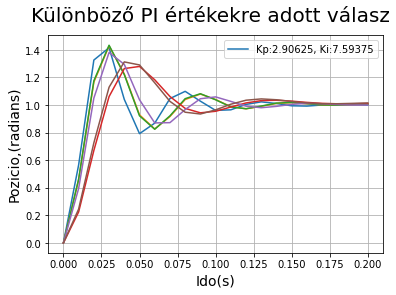

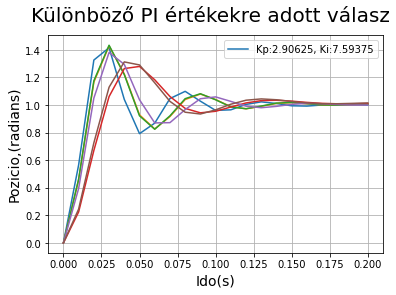

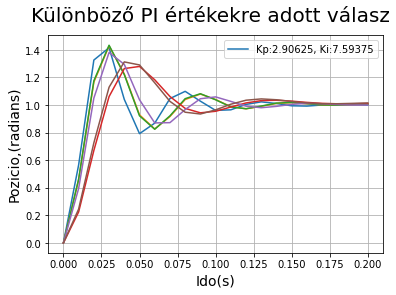

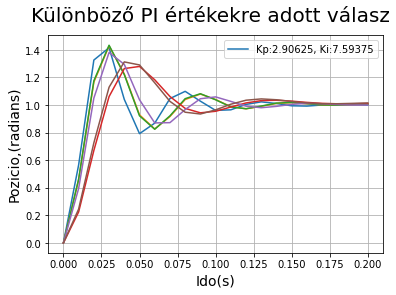

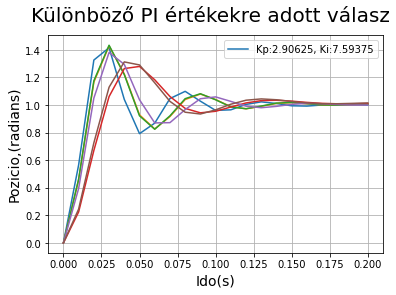

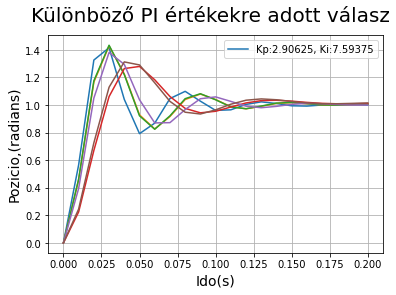

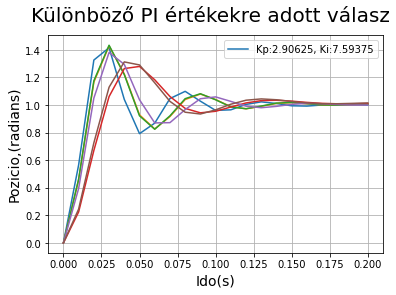

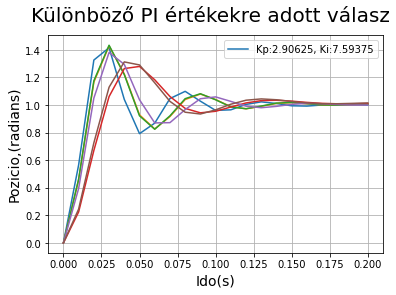

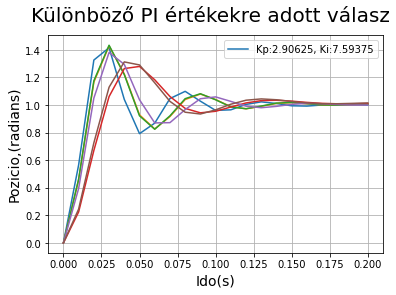

<Figure size 432x288 with 0 Axes>

In [ ]:
oc.eval("t=0:0.01:0.2;")
t=oc.pull('t')
fig=plt.figure() 
#plt.subplot(gen,1,1)
%matplotlib inline
for i in range(1,gen):
 #fig = plt.figure(i)
 fig=plt.figure(i) 
 fitness_array=[]  
 for j in range(0,len(cur)):
  [Kp,Ki,Kd]=kpid(lineofarray(cur,j))
  [y,_t]=pid_cal(Kp,Ki,Kd)
  #plt.subplot(gen,1,i)
  plt.plot(_t,y) #x,y
  fitness_array.append(fitness(_t,y))
  #display('Fitnessz '+str(fitness_array[j-1]))
  plt.legend(["Kp:"+str(Kp)+", Ki:"+str(Ki)])#+", Kd:"+str(Kd)])
 oc.push('fitness',fitness_array)
 oc.eval("[u,v]=max(fitness);")
 oc.eval("elit=cur(v,:);")
 oc.eval("disp(cur)")
 selection()
 recomb()
 mutation()
 oc.eval("cur=recombinated")
 #oc.eval("disp(cur)")
 #oc.eval("disp(elit)")
 fig.suptitle('Különböző PI értékekre adott válasz', fontsize=20) 
 plt.xlabel(str("Ido(s)"),fontsize=14)
 plt.ylabel(str("Pozicio,(radians)"),fontsize=14)
 plt.grid('both')
 plt.yscale("linear")
 fig=plt.figure()
 fig.savefig("plot"+str(i)+".png")
 #break

#Image("plot.png")

plot1.png  plot3.png  plot5.png  plot7.png  plot9.png
plot2.png  plot4.png  plot6.png  plot8.png  sample_data/


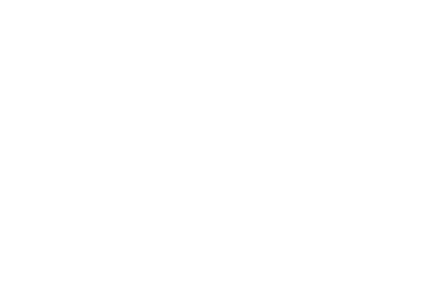

In [ ]:
%ls
Image("plot5.png")

In [ ]:
"""desired=[1,1,1,1,1,1,1,1];
gen=100;
cur=(randi(5,8))>=3;
for k=1:gen
fitness=sum((cur-desired==0)');%fitness mennyi egyezik a keresettel
[u,v]=max(fitness);
elit=cur(v,:);
for i=1:length(fitness) %bubblesortal való szortírozás
    for j=i+1:length(fitness)
        if(fitness(i)>fitness(j))
            var=fitness(i);
            fitness(i)=fitness(j);
            fitness(j)=var;
            var=cur(i,:);
            cur(i,:)=cur(j,:);
            cur(j,:)=var;
            end
    end
end  %fitness és sorba rakás fitness szerint
    avgFitness=mean(fitness);
    % normalized fitness (ff)
    normFitness=fitness/avgFitness;
    % percentage for roulette wheel
    percFitness=normFitness/length(fitness);
    % cumulative fitness fKum
    fKum=100*cumsum(percFitness);
    rndNums=randi(100,1,length(fitness));
    selectedInds=zeros(1,length(fitness));
    
    for i=1:length(fitness) %rulett kerék
        rnd=rand()*100;
        for j=1:length(fitness)
            if fKum(j)>rnd
                selectedInds(i)=j;
                break;
            end
        end
        
    end
    
    %selection
    selected=[]; %kiválasztás
    for i=1:length(selectedInds)
    selected(i,:)=cur(selectedInds(i),:);
    end
    %recombination
    recombinated=[];
    for i=1:2:length(selectedInds)
    a=selected(i,:);%apuci
    b=selected(i+1,:);%anyuci
    r=randi(8);
    a_part=a(1:r);%gyerek_part1
    b_part=b(r+1:8);%gyerek_part2
    recombinated(i,:)=[a_part,b_part];
    a_part=a(r+1:8);%gyerek_part3
    b_part=b(1:r);%gyerek_part4
    recombinated(i+1,:)=[b_part,a_part];    
    end
    
    %Mutation
    for i=1:length(selectedInds)
        for j=1:8
        if(randi(10)==1)% 1 a 10 hez mutál egyet
            recombinated(i,j)=xor(recombinated(i,j)==1,1)*1; %xorral bit hely csere
            end
        end
    end
    fmin=sum((cur-desired==0)');%fitness mennyi egyezik a keresettel
    [u,v]=min(fmin);
    recombinated(v,:)=elit;
  cur=recombinated;  
  disp(mean(fmin));
end
disp('Utolsó eredmény')
disp(cur)"""


"desired=[1,1,1,1,1,1,1,1];\ngen=100;\ncur=(randi(5,8))>=3;\nfor k=1:gen\nfitness=sum((cur-desired==0)');%fitness mennyi egyezik a keresettel\n[u,v]=max(fitness);\nelit=cur(v,:);\nfor i=1:length(fitness) %bubblesortal való szortírozás\n    for j=i+1:length(fitness)\n        if(fitness(i)>fitness(j))\n            var=fitness(i);\n            fitness(i)=fitness(j);\n            fitness(j)=var;\n            var=cur(i,:);\n            cur(i,:)=cur(j,:);\n            cur(j,:)=var;\n            end\n    end\nend  %fitness és sorba rakás fitness szerint\n    avgFitness=mean(fitness);\n    % normalized fitness (ff)\n    normFitness=fitness/avgFitness;\n    % percentage for roulette wheel\n    percFitness=normFitness/length(fitness);\n    % cumulative fitness fKum\n    fKum=100*cumsum(percFitness);\n    rndNums=randi(100,1,length(fitness));\n    selectedInds=zeros(1,length(fitness));\n    \n    for i=1:length(fitness) %rulett kerék\n        rnd=rand()*100;\n        for j=1:length(fitness)\n    